In [ ]:
#imports
import numpy as np
import pandas as pd


In [ ]:
df=pd.read_csv("./TrainingBatchDataset/insurance.csv")

In [ ]:
df.head()

In [ ]:
def get_outliers(df,feature):
    q1=df[feature].quantile(.25)
    q3=df[feature].quantile(.75)
    IQR=q3-q1

    lowerBound=q1-(1.5*IQR)
    upperBound=q3+(1.5*IQR)

    return df.index[(df[feature]<lowerBound)|(df[feature]>upperBound)]


def remove_outliers(df):
    outlier_index=[]
    for i in df.dtypes[df.dtypes!=object].keys():
        index=get_outliers(df,i)
        if len(index)>0:
            outlier_index.extend(index)
    outlier_index=set(outlier_index)
    print(len(outlier_index))
    if len(outlier_index)>0:
        df=df.drop(outlier_index)
    return df
    


new_data=remove_outliers(df)        
print(len(new_data))
print(len(df))

In [ ]:
df.head()
dd=(df.isna().sum()/len(df))*100
zip(dd.index,dd.values)
for i in dd.index:
    print(i)
    print(dd[i])
    

In [ ]:
df.columns
df.dtypes.index
print(df.dtypes.values[0])
if 'int' in str(df.dtypes.values[0]):
    print("yes")
else:
    print("NO")
sum(df.dtypes.index==['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'expenses'])


In [ ]:
#imports
import numpy as np
import pandas as pd
import json
import os
import re
from ApplicationLogger.logger import logger
class TrainValidation:
    def __init__(self):
        self.BatchFilePath="./TrainingBatchDataset"
        self.TrainSchemaPath="./DatasetSchema/TrainingDataSchema.json"
        self.GoodDataPath="./TrainingGoodDataset"
        self.BadDataPath="./TrainingBadDataset"
        self.TrainingLogPath="./TrainingLog"
        self.Trainlogger=logger(self.TrainingLogPath)
        
        
    def getTrainSchema(self):
        self.Trainlogger.log("info","Started reading TrainSchema json")
        try:
            f = open (self.TrainSchemaPath, "r")
            train_schema_json=json.loads(f.read())
            f.close()
        except Exception as e:
            self.Trainlogger.log("error","Error occured while reading training schema")
        self.Trainlogger.log("info","Ended reading TrainSchema json")
        return train_schema_json
    
    def fileNameValidation(self,file,pattern):
        self.Trainlogger.log("info","starting file name validation")
        result=False
        try:
            if re.match(pattern,file):
                result=True
            else:
                self.Trainlogger.log("info","File name is not matched")
                result=False
        except Exception as e:
            self.Trainlogger.log("error",f"Error occured while validating file name {e}")
        self.Trainlogger.log("info","ending file name validation")
        return result
        
    def checkColumnType(self,actualTypes,requiredTypes):
        self.Trainlogger.log("info","starting column Type validation")
        result=False
        try:
            result=sum([i in j for i,j in zip(requiredTypes,actualTypes)])==len(requiredTypes)
            self.Trainlogger.log("info","Ending column Type validation")
        except Exception as e:
            self.Trainlogger.log("error",f"Error occured while validating column Types {e}")
        return result
    
    def checkColumnNames(self,actualColumnName,columnNames):
        self.Trainlogger.log("info","starting column Names validation")
        result=False
        try:
            result=sum(columnNames==actualColumnName)==len(columnNames)
            self.Trainlogger.log("info","Ending column Names validation")
        except Exception as e:
            self.Trainlogger.log("error",f"Error occured while validating column Names {e}")
        return result
    
    def allCol_LessThan95_NA(self,data):
        self.Trainlogger.log("info"," starting >95% Na validation")
        try:
            dd=(data.isna().sum()/len(data))*100
            result=True
            for i in dd.index:
                if dd[i]>95:
                    self.Trainlogger.log("info",f"column {i} have >95% NA so we reject this dataset")
                    result=False
                    break
        except Exception as e:
            self.Trainlogger.log("error",f"Error occured while validating allCol_LessThan95_NA {e}")  
        self.Trainlogger.log("info",f"completing >95% NA validation")
        return result
    
    def isAllcolumnPresent(self,data,columns):
        self.Trainlogger.log("info","Starting column values and data type check")
        columnLength,actualLength=len(columns),len(data.columns)
        actualColumnName,actualColumnType=data.dtypes.index,data.dtypes.values.astype("str")
        columnNames,columnTypes=list(columns.keys()),columns.values()
        try:
            if actualLength==columnLength:
                if self.checkColumnNames(actualColumnName,columnNames):
                    if self.checkColumnType(actualColumnType,columnTypes):
                        if self.allCol_LessThan95_NA(data):
                            self.Trainlogger.log("info","Column validation succesfull")
                            return True
                        else:
                            return False
                else:
                    return False
            else:
                return False
        except Exception as e:
            self.Trainlogger.log("error",f"error occured during column validation {e}")
            return False
            
    
    def replace_NaWithNULL(self,data):
        self.Trainlogger.log("info","Replacing NA values with NULL")
        try:
            data=data.fillna("NULL")
        except Exception as e:
            self.Trainlogger.log("error",f"error while Replacing NA values with NULL {e}")
        return data
    
    def moveGoodData(self,data,filename):
        self.Trainlogger.log("info","started data moving to good data folder")
        try:
            data.to_csv(f"{self.GoodDataPath}/{filename}",header=True,index=None)
            self.Trainlogger.log("info","ending data movement to good data folder")
            return True
        except:
            self.Trainlogger.log("error",f"error occured while moving file to good data folder {e}")
            return False
            
    
    def moveBadData(self,data,filename):
        self.Trainlogger.log("info","started data moving to bad data folder")
        try:
            data.to_csv(f"{self.BadDataPath}/{filename}",header=True,index=None)
            self.Trainlogger.log("info","ending data movement to bad data folder")
            return True
        except Exception as e:
            self.Trainlogger.log("error",f"error occured while moving file to bad data folder {e}")
            return False
    
    def ValidateTrainData(self):
            #read the train data schema
            self.Trainlogger.log("info","Starting the Train Validation")
            train_schema_json=self.getTrainSchema()
            pattern=train_schema_json["pattern"]
            columns=train_schema_json["columnname"]
            for fileName in os.listdir(self.BatchFilePath):
                is_valid=self.fileNameValidation(fileName,pattern)
                if is_valid:
                    data=pd.read_csv(f"{self.BatchFilePath}/{fileName}")
                    if self.isAllcolumnPresent(data,columns):
                        data=self.replace_NaWithNULL(data)
                        self.moveGoodData(data,fileName)
                    else:
                        self.moveBadData(data,fileName)
            self.Trainlogger.log("info","Ending the Train Validation")

            

obj=TrainValidation()
obj.ValidateTrainData()



In [ ]:
for i in df.isna().sum()/len(df):
    if i>95:
        print("bad")
    else:
        print("good")
        print(i)


In [ ]:
pd.get_dummies(df,drop_first=True)

In [ ]:
from ApplicationLogger.logger import logger

logger("./test").log("sdadas","dasdas")

In [ ]:

from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
from cassandra.query import SimpleStatement, BatchStatement
from cassandra.policies import RetryPolicy
import numpy as np
import config
from ApplicationLogger.logger import logger
from TrainingDataValidation.ValidateTrainingData import TrainValidation
import pandas as pd

class TrainDataDetails:
    def __init__(self,schema):
        self.columns=self.dict_to_array(schema["columnname"].keys())
        self.tablename=schema["filename"]
        self.filename=schema["filename"]
        self.datatypes=self.dict_to_array(schema["columnname"].values())

    def getQueryDetails(self):
        self.tableColumns=np.concatenate([["id"],self.columns])
        self.insert=f"insert into insurance.{self.tablename} ({(',').join(self.tableColumns)}) values ({(',').join(['%s' for i in range(len(self.tableColumns))])})"
        self.select=f"select * from insurance.{self.tablename}"
        self.truncate=f"truncate insurance.{self.tablename}"
        self.create=f"create table IF NOT EXISTS insurance.{self.tablename} ({(',').join([f'{i} int primary key' if i=='id' else f'{i} text' for i in self.tableColumns])})"
        self.drop=f"drop table IF EXISTS insurance.{self.tablename}"
        print(self.insert,self.select,self.truncate,self.create)
        return self
    def as_dict(self):
        return {"columns":self.columns,"tablename":self.tablename,"filename":self.filename,"datatypes":self.datatypes}
    
    def dict_to_array(self,dictList):
        return np.array(list(dictList))
    
class dboperations:
    def __init__(self):
        self.TrainingLogPath="./TrainingLog/DataIngestionLog"
        self.TrainDbLogger=logger(self.TrainingLogPath)
    def CreateSession(self):
        try:
            self.TrainDbLogger.log("info",f"creating DB connection starts ")
            cloud_config= {
                'secure_connect_bundle': config.BUNDLE_PATH
            }
            auth_provider = PlainTextAuthProvider(config.CLIENT_ID, config.SECRET_KEY)
            cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
            session = cluster.connect()
            self.TrainDbLogger.log("info",f"created DB connection")
            return session
        except Exception as e:
            self.TrainDbLogger.log("error",f"error during db connection {e}")
            raise Exception(e)

    def executeQuery(self,query,values=[]):
        try:
            self.TrainDbLogger.log("info",f"executing query starts")
            session=self.CreateSession()
            if len(values)>0:
                query=self.prepareQuery(session,query,values)
            result=session.execute(query)
            self.TrainDbLogger.log("info",f"Ending query execution")
            return result
        except Exception as e:
            self.TrainDbLogger.log("error",f"error during query execution {e}")
            raise Exception(e)

    def executeQueryOne(self,query,values=[]):
        try:
            self.TrainDbLogger.log("info",f"starting one query execution")
            session=self.CreateSession()
            if len(values)>0:
                query=self.prepareQuery(session,query,values)
            result=session.execute(query).one()
            self.TrainDbLogger.log("info",f"Ending one query execution")
            return result
        except Exception as e:
            self.TrainDbLogger.log("error",f"error during query execution {e}")
            raise Exception(e)
            
    def truncateTable(self,query):
        try:
            self.TrainDbLogger.log("info",f"starting Truncate table Operation")
            result=self.executeQueryOne(query)
            self.TrainDbLogger.log("info",f"Ending Truncate table Operation")
        except Exception as e:
            self.TrainDbLogger.log("error",f"error during Truncate table {e}")
            raise Exception(e)
    
    def createTable(self,query):
        try:
            self.TrainDbLogger.log("info",f"starting  create table Operation")
            result=self.executeQueryOne(query)
            self.TrainDbLogger.log("info",f"Ending create table Operation")
        except Exception as e:
            self.TrainDbLogger.log("error",f"error during creating table {e}")
            raise Exception(e)
        
    def dropTable(self,query):
        try:
            self.TrainDbLogger.log("info",f"starting drop table Operation")
            result=self.executeQuery(query)
            self.TrainDbLogger.log("info",f"Ending drop table Operation")
        except Exception as e:
            self.TrainDbLogger.log("error",f"error during dropping table {e}")
            raise Exception(e)
    
    def getTrainData(self,query):
        try:
            self.TrainDbLogger.log("info",f"starting get train data Operation")
            result=self.executeQuery(query)
        except Exception as e:
            self.TrainDbLogger.log("error",f"error during getting data from table using select query {e}")
        self.TrainDbLogger.log("info",f"Ending get train data Operation")
        return result
        
    def prepareBatchData(self,query,batchList,columns):
        batch=BatchStatement()
        try:
            self.TrainDbLogger.log("info",f"starting Batch Data query preperation")
            for i in range(0,len(batchList)):
                values=tuple([df.loc[i][j] if j=="id" else str(df.loc[i][j])  for j in columns])
                print(values)
                print(query)
                batch.add(SimpleStatement(query),values )
            self.TrainDbLogger.log("info","Ending Batch Data query preperation")
        except Exception as e:
            self.TrainDbLogger.log("error",f"Error while preparing batch insert query {e}")
        return batch
        
    def insertBatchData(self,query,batchList,columns):
        try:
            self.TrainDbLogger.log("info",f"starting Batch data insertion")
            session=self.CreateSession()
            batch=self.prepareBatchData(query,batchList,columns)
            result=session.execute(batch)
            self.TrainDbLogger.log("info",f"Ending Batch data insertion")
            return 1
        except Exception as e:
            self.TrainDbLogger.log("error",f"error during batch data insertion {e}")
            raise Exception(e)

    def prepareQuery(self,session,query,values):
        try:
            self.TrainDbLogger.log("info",f"starting query preperation for execution")
            stmt=session.prepare(query)
            qry=stmt.bind(values)
            self.TrainDbLogger.log("info",f"Ending query preperation for execution")
            return qry
        except Exception as e:
            self.TrainDbLogger.log("error",f"error during query preparation {e}")
            raise Exception(e)
#schema=TrainValidation().getTrainSchema()
#schema=pd.read_json(r"./DatasetSchema/testConfig.json")
#print(schema)
schema={
    "filename":"test",
    "pattern":"^test_[0-9]{8,8}.csv$",
    "columnname":{"age":"int",
                  "name":"object"
                 }
}

#TableName=f"insurance.{schema['filename']}"
##createQuery="create table IF NOT EXISTS insurance.test1(id int primary key,name text)"
#selectQuery="select * from insurance.test"
trainDetails=TrainDataDetails(schema).getQueryDetails()


db=dboperations()

#insert data
df=pd.DataFrame([[20,"hi"],[12,"hello"],[34,"test"],[33,"dsadfs"]],columns=["age","name"])
df["id"]=df.index
db.insertBatchData(trainDetails.insert,df,trainDetails.tableColumns)

#drop table
db.dropTable(trainDetails.drop)
#create table
result=db.createTable(trainDetails.create)

#truncate table
db.truncateTable(trainDetails.truncate)

#insert data
df=pd.DataFrame([[20,"hi"],[12,"hello"],[34,"test"],[33,"dsadfs"]],columns=["age","name"])
df["id"]=df.index
db.insertBatchData(trainDetails.insert,df,trainDetails.tableColumns)

#select data
result=db.getTrainData(trainDetails.select)

for i in result:
    print(i)



In [ ]:
print(db)

In [ ]:
schema["columnname"]["id"]=1
tuple(schema["columnname"])

In [ ]:
tt=f"{(',').join(['?' for i in range(5)])}"
print(tt)

In [ ]:
from TrainingDataIngestion.TrainDataDetails import TrainDataDetails
from TrainingDataIngestion.dbOperation import dboperations
from ApplicationLogger.logger import logger
import os
import pandas as pd
class DataIngestion:
    def __init__(self):
        self.logPath="./TrainingLog/DataIngestionLog"
        self.logger=logger(self.logPath)
        try:
            self.queryDetails=TrainDataDetails().getQueryDetails()
            self.goodDataPath="./TrainingGoodDataset"
            self.trainingInputPath="./TrainingInputData"
            self.db=dboperations()
        except Exception as e:
            self.logger.log("error",f"Error while initializing data ingestion ERROR:{e}")
            
    def getGoodData(self):
        try:
            self.logger.log("info",f"starting get good data")
            df=[]
            for fileName in os.listdir(self.goodDataPath):
                if fileName.__contains__("csv"):
                    temp=pd.read_csv(self.goodDataPath+"/"+fileName)
                    df.append(temp)
            dataset=pd.concat(df)
            self.logger.log("info",f"Ending get good data")
        except Exception as e:
            self.logger.log("error",f"Error while getting good data ERROR:{e}")
        return dataset
    
    def addID(self,df):
        df["id"]=df.index
        return df
    def dropID(self,df):
        df=df.drop("id",axis=1)
        return df
        
    
    def UploadDataToDB(self):
        try:
            self.logger.log("info",f"Starting data upload to DB")
            #get query details 
            queryDetails=self.queryDetails
            #get good data 
            df=self.getGoodData()
            if len(df)>0:
                #initialize DB connection
                db=self.db
                #add id to dataSet
                df=self.addID(df)
                #drop table
                db.dropTable(queryDetails.drop)
                #create table
                db.createTable(queryDetails.create)
                #insert data
                db.insertBatchData(queryDetails.insert,df,queryDetails.tableColumns)
                #close db connection
                db.close()
                self.logger.log("info",f"data uploaded to DB successfully and created Training input csv file")
                return 1
        except Exception as e:
                self.logger.log("error",f"Error while uploading data to DB ERROR:{e}")
                raise Exception(e)
                return 0
            
        
    def getDataFromDB(self):
        try:
            self.db=dboperations()
            self.logger.log("info",f"Starting get data from DB")
            result=self.db.getTrainData(self.queryDetails.select)
            self.logger.log("info",f"Ending get data from DB")
            self.db.close()
            df=self.ConvertResultsetToDF(result)
            return df
        except Exception as e:
            self.logger.log("error",f"error while getting data from DB :{e}")
            raise Exception(e)
            
    def ConvertResultsetToDF(self,result):
        try:
            self.logger.log("info",f"Starting convert Rs to DF")
            df=pd.DataFrame(result.all())
            df=self.dropID(df)
            self.logger.log("info",f"Ending convert Rs to DF")
            return df
        except Exception as e:
            self.logger.log("error",f"error while converting Rs to DF{e}")
            raise Exception(e)
            
    
    def CreateInput_CSVFromDB(self):
        try:
            self.logger.log("info",f"Starting create training input")
            df=self.getDataFromDB()
            df.to_csv(f"{self.trainingInputPath}/{self.queryDetails.filename}",header=True,index=None)
            self.logger.log("info",f"Ending create training input")
            return 1
        except Exception as e:
            self.logger.log("error",f"error while converting df to CSV{e}")
            return 0
        
        

        
DI=DataIngestion()
#Upload Data
DI.UploadDataToDB()
#Conver data to csv for training
DI.CreateInput_CSVFromDB()

#for row in result:
#    print(row)

In [ ]:
DI.ConvertResultsetToDF(result)

In [ ]:
for row in result:
    print(row)

In [ ]:
from TrainingDataValidation.ValidateTrainingData import TrainValidation
from TrainingDataIngestion.DataIngestion import DataIngestion
import pandas as pd

class TrainModel:
    def train(self):
        #initialize object for TrainValidation
        validate=TrainValidation()
        #validating Training data
        validate.ValidateTrainData()
        #initializing DataIngestion Object
        DI=DataIngestion()
        #Upload Data
        DI.UploadDataToDB()
        #Conver data to csv for training
        DI.CreateInput_CSVFromDB()
        
#Reading the Training Input Data
TrainModel().train()
pd.read_csv("./TrainingInputData/insurance.csv")
    


In [1]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kneed import KneeLocator

#data Preprocessing
class dataPreprocessing:
    def __init__(self):
        self.trainPath="./TrainingInputData/insurance.csv"
    def get_outliers(self,df,feature):
        q1=df[feature].quantile(.25)
        q3=df[feature].quantile(.75)
        IQR=q3-q1

        lowerBound=q1-(1.5*IQR)
        upperBound=q3+(1.5*IQR)

        return df.index[(df[feature]<lowerBound)|(df[feature]>upperBound)]


    def remove_outliers(self,df,target):
        outlier_index=[]
        for i in df.dtypes[df.dtypes!=object].keys():
            if target!=i:
                index=get_outliers(df,i)
                if len(index)>0:
                    outlier_index.extend(index)
        outlier_index=set(outlier_index)
        print(len(outlier_index))
        if len(outlier_index)>0:
            df=df.drop(outlier_index)
        return df

    def getTrainingData(self):
        data=pd.read_csv(self.trainPath)
        #data=remove_outliers(data,"")
        X=data.iloc[:,:-1]
        Y=data.iloc[:,-1]
        return X,Y
    def encodeCategoricalData(self,X):
        categorical=np.array(X.dtypes[X.dtypes==object].index)
        X=pd.get_dummies(X,drop_first=1)
        return X
    def imputeNullValues(self,X):
        totalNullValues=sum(X.isna().sum().values)
        if totalNullValues!=0:
            imputer=KNNImputer(n_neighbours=5,weights="distance")
            X=imputer.fit_transform(X)
        return X

    def featureSelection(self,x,y):
        features=x.columns
        lasso=LassoCV(cv=5)
        lasso.fit(x,y)
        selected_features=features[np.where(lasso.coef_!=0)]
        return selected_features

#X_values=X.values
#Y_values=Y.values




    



# pca=PCA()



# print(n_clstr)
# clstr_count=0
# model_list=[]



from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso,LassoCV

class trainModel:
    def __init__(self):
        pass
    def getK_forCluster(self,X):
        inertia_list=[]
        for i in range(1,10):
            kmeans=KMeans(n_clusters=i,init="k-means++", random_state=23)
            kmeans.fit(X)
            inertia_list.append(kmeans.inertia_)
        #plt.plot(range(1,10),inertia_list)
        #plt.xlabel("clusters")
        #plt.ylabel("Intertia")
        #plt.show()
        kn=KneeLocator(range(1,10),inertia_list,curve="convex",direction="decreasing")
        n_clstr=kn.knee
        return n_clstr

    def ClusterData(self,X,Y):
        n_clstr=self.getK_forCluster(X)
        kmeans=KMeans(n_clusters=n_clstr,init="k-means++", random_state=23)
        X["clusters"]=pd.Series( kmeans.fit_predict(X))
        X["Target"]=Y
        return X,n_clstr

    def getBestEstimator(self,model,parameter,x_train,y_train):
        grid=GridSearchCV(model,param_grid=parameter,n_jobs=4)
        grid.fit(x_train,y_train)
        best_estimator=grid.best_estimator_
        return best_estimator

    def IsModelOverFitting(self,model,x_train,y_train,x_test,y_test):
        train_score=round(model.score(x_train,y_train),2)*100
        test_score=round(model.score(x_test,y_test),2)*100
        isDiff_moreThan5Percent=train_score-test_score
        if isDiff_moreThan5Percent>5:
            return {"overfitting":True,"train_score":train_score,"test_score":test_score}
        else:
            return {"overfitting":False,"train_score":train_score,"test_score":test_score}


    def get_ModelParameters(self,ModelName):
        parameters={
            "RandomForest":  {
                            'max_depth': [2,3],
                            'criterion':["mse","mae"],
                            'max_features': ['auto','sqrt', 'log2'],
                            'min_samples_leaf': [15,25,35],
                            'min_samples_split': [10,20,30],
                            'n_estimators': [100],
                            'max_samples':[.8],
                            'ccp_alpha':[0.5,10,50,100]
                             },
            "GradientBoost":{
                            'max_depth': [2,3], 
                            'max_features': ['auto', 'log2'],
                            'min_samples_leaf':[15,20,25,35],
                            'min_samples_split': [10,20,30],
                            'subsample':[0.8],
                            'n_estimators': [100],
                            'ccp_alpha':[0.5,10,50,100]     
                             },
            "XgBoost":{"booster":["gbtree"],
                       "objective":['reg:squarederror'],
                       "max_depth":[2],
                       "subsample":[0.8],
                       "reg_lambda":[25,30,50,80],
                       "reg_alpha":[25,30,50,80],
                       "n_estimators":[100],
                       "learning_rate":[0.1],
                       "min_child_weight":[30,40,50],
                       "colsample_bylevel":[0.8],
                       "colsample_bytree":[0.8],
                       "colsample_bynode":[0.8],
                       "gamma":[0.2,0.3]
                      }
            }
        if ModelName in parameters:
            return parameters[ModelName]
        else:
            return None    

    def getModels(self):
        models={
    #    "linear":LinearRegression(),
    #    "Ridge":Ridge(),
    #    "SVM":SVR(),
    #    "XgBoost":XGBRegressor(),
       "RandomForest":RandomForestRegressor(),
       "GradientBoost":GradientBoostingRegressor()
            }
        return models
    def getBestTrainedModel(self,data,n_clstr):
        #print(data.head(2))
        models=self.getModels()
        cluster_wise_best_estimators={}
        Trained_model_details=[]
        for i in range(0,n_clstr):
            clstr_x=data[data["clusters"]==i]
            #print(clstr_x["clusters"].unique())
            clstr_x=clstr_x.drop(["clusters","Target"],axis=1)
            clstr_y=data[data["clusters"]==i]["Target"]
            #scale=MinMaxScaler()
            #clstr_x[["age","bmi","children"]]=scale.fit_transform(clstr_x.loc[:,["age","bmi","children"]])
            #print(clstr_x.head(1))
            #pca=PCA()
            #pca.fit(clstr_x)
            #clstr_x=pca.transform(clstr_x)
            #x_train=scalar.fit_transform(x_test)
            x_train,x_test,y_train,y_test=train_test_split(clstr_x,clstr_y,test_size=0.3,random_state=12)
            large=0
            for key,model in zip(models.keys(),models.values()):
                #getting the hyperparamters for model
                parameter=self.get_ModelParameters(key)
                if parameter!=None:
                    best_estimator=self.getBestEstimator(model,parameter,x_train,y_train)
                    #best_estimator=RandSearch.best_estimator_
                    scoreDetails=self.IsModelOverFitting(best_estimator,x_train,y_train,x_test,y_test)
                    if not scoreDetails["overfitting"] and scoreDetails["train_score"]>large:
                        cluster_wise_best_estimators[i]={"name":key,"model":best_estimator,
                                                         "score_details":scoreDetails}
                        Trained_model_details.append({"cluster":i,"name":key,
                                                                            "score_details":scoreDetails})
                        large=scoreDetails["train_score"]
                    else:
                        Trained_model_details.append({"cluster":i,"name":key,"score_details":scoreDetails})
                else:
                    model.fit(x_train,y_train)
                    scoreDetails=IsModelOverFitting(model,x_train,y_train,x_test,y_test)
                    if not scoreDetails["overfitting"] and scoreDetails["train_score"]>large:
                        cluster_wise_best_estimators[i]={"name":key,"model":model,"score_details":scoreDetails}
                        Trained_model_details.append({"cluster":i,"name":key,"score_details":scoreDetails})
                        large=scoreDetails["train_score"]
                    else:
                        Trained_model_details.append({"cluster":i,"name":key,"score_details":scoreDetails})
        return Trained_model_details,cluster_wise_best_estimators


data_prep=dataPreprocessing()
X,Y=data_prep.getTrainingData()
X=data_prep.encodeCategoricalData(X)
X=data_prep.imputeNullValues(X)
selected_features=data_prep.featureSelection(X,Y)
X=X[selected_features]

trainModel=ModelBuilding()
data,n_clstr=trainModel.ClusterData(X,Y)
Trained_model_detailss,cluster_wise_best_estimator=trainModel.getBestTrainedModel(data,n_clstr)
for i in Trained_model_detailss:
    print(i)
print(cluster_wise_best_estimator)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


{'cluster': 0, 'name': 'RandomForest', 'score_details': {'overfitting': False, 'train_score': 85.0, 'test_score': 86.0}}
{'cluster': 0, 'name': 'GradientBoost', 'score_details': {'overfitting': False, 'train_score': 87.0, 'test_score': 86.0}}
{'cluster': 1, 'name': 'RandomForest', 'score_details': {'overfitting': False, 'train_score': 85.0, 'test_score': 87.0}}
{'cluster': 1, 'name': 'GradientBoost', 'score_details': {'overfitting': False, 'train_score': 88.0, 'test_score': 87.0}}
{0: {'name': 'GradientBoost', 'model': GradientBoostingRegressor(ccp_alpha=0.5, max_depth=2, max_features='auto',
                          min_samples_leaf=20, min_samples_split=20,
                          subsample=0.8), 'score_details': {'overfitting': False, 'train_score': 87.0, 'test_score': 86.0}}, 1: {'name': 'GradientBoost', 'model': GradientBoostingRegressor(ccp_alpha=100, max_depth=2, max_features='auto',
                          min_samples_leaf=15, min_samples_split=10,
                        

In [ ]:
            print("grid search")
#             RandSearch=RandomizedSearchCV(estimator=model,n_iter=50,cv=3,n_jobs=4
#                                           ,param_distributions=parameters[key])
            

#             RandSearch.fit(x_train,y_train)
#             best_params=RandSearch.best_params_
#             print(f"best params:{best_params}")

#             newParam =  {
#                     'max_depth': [best_params["max_depth"]],
#                     'criterion':[best_params["criterion"]],
#                     'max_features': [best_params["max_features"]],
#                     'min_samples_leaf':[int(abs(i)) for i in range(best_params["min_samples_leaf"]-5
#                                                                    ,best_params["min_samples_leaf"]+10
#                                                                    ,5)],
#                     'min_samples_split': [int(abs(i)) for i in range(best_params["min_samples_split"]-5
#                                                                      ,best_params["min_samples_split"]+10
#                                                                      ,5)],
#                     'n_estimators': [best_params["n_estimators"]+20,best_params["n_estimators"],best_params["n_estimators"]-20],
#                     'max_samples':np.linspace(best_params["max_samples"]-.2,
#                                               best_params["max_samples"]+.2,5),
#                     'ccp_alpha': [int(abs(i)) for i in range(best_params["ccp_alpha"]-5
#                                                                      ,best_params["ccp_alpha"]+10
#                                                                      ,5)]}
#             print(f"New params : {newParam}")


In [ ]:
np.linspace(5-4,5+4,5)

In [ ]:
pt -t onedork


In [ ]:
[int(abs(i)) for i in range(best_params["min_samples_leaf"]-10,best_params["min_samples_leaf"]+20,10)]

In [ ]:
best_params["min_samples_leaf"]

In [16]:
train_score=85
test_score=90
isDiff_moreThan5Percent=train_score-test_score
isDiff_moreThan5Percent

-5

In [20]:
df = pd.read_csv("./TrainingInputData/insurance.csv")

In [21]:
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,38,female,19.5,2,no,northwest,6933.24
1,31,female,25.8,2,no,southwest,4934.71
2,34,female,31.9,1,yes,northeast,37701.88
3,52,male,32.2,3,no,northeast,11488.32
4,37,male,46.5,3,no,southeast,6435.62


In [22]:
df.corr()

,age,bmi,children,expenses
age,1.000000,0.109341,0.042469,0.299008
bmi,0.109341,1.000000,0.012645,0.198576
children,0.042469,0.012645,1.000000,0.067998
expenses,0.299008,0.198576,0.067998,1.000000


In [23]:
df = pd.read_csv("./TrainingInputData/insurance.csv")
temp=encodeCategoricalData(df)
temp=imputeNullValues(temp)
temp

,age,bmi,children,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,38,19.5,2,6933.24,0,0,1,0,0
1,31,25.8,2,4934.71,0,0,0,0,1
2,34,31.9,1,37701.88,0,1,0,0,0
3,52,32.2,3,11488.32,1,0,0,0,0
4,37,46.5,3,6435.62,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
1333,42,26.2,1,7046.72,0,0,0,1,0
1334,19,17.8,0,1727.79,0,0,0,0,1
1335,61,29.9,3,30942.19,0,1,0,1,0
1336,43,30.1,3,8410.05,1,0,1,0,0


In [37]:
temp.corr()["expenses"].drop("expenses",axis=0)

age                 0.299008
bmi                 0.198576
children            0.067998
sex_male            0.057292
smoker_yes          0.787251
region_northwest   -0.039905
region_southeast    0.073982
region_southwest   -0.043210
Name: expenses, dtype: float64

<AxesSubplot:>

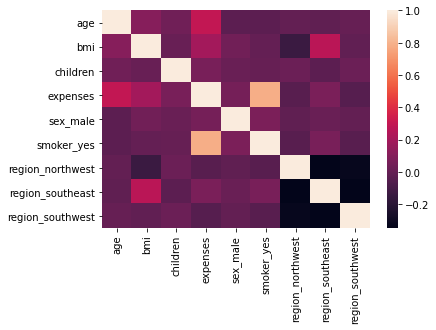

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(temp.corr())

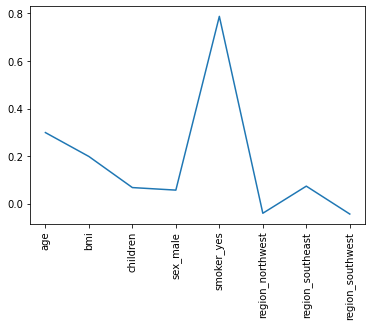

In [41]:
plt.plot(temp.corr()["expenses"].drop("expenses",axis=0).index,
         temp.corr()["expenses"].drop("expenses",axis=0))
plt.xticks(rotation=90)
plt.show()

In [85]:
from sklearn.linear_model import LassoCV

lst=[]
x_t=temp.drop("expenses",axis=1)
corr_score=abs(temp.corr()["expenses"]).drop("expenses",axis=0).sort_values(ascending=True)
#print(corr_score)
y_t=temp["expenses"]
score_limit=[0.1,0.2,0.3,0.4,0.5,0.6,0.7]
for i in range(0,len(corr_score)-3):
    print(f"more than {corr_score[i]}")
    index=np.array(corr_score[corr_score>corr_score[i]].index)
    #print(np.array(abs(corr_score[corr_score>abs(i)])))
    x_new=x_t[index]
    lass=LassoCV(cv=5)
    lass.fit(x_new,y_t)
    print(lass.coef_)
    print(index[np.where(lass.coef_>0)])
    print(lass.score(x_new,y_t))



more than 0.039904880577768136
[ -352.49628491    -0.           438.66545794  -403.65693355
   328.71538885   257.12834779 23514.5770141 ]
['children' 'bmi' 'age' 'smoker_yes']
0.7503612258537318
more than 0.043210011130927886
[   -0.           437.0797533   -277.92438631   326.38279302
   257.18680469 23519.14586921]
['children' 'bmi' 'age' 'smoker_yes']
0.7498941796051009
more than 0.05729206999169416
[  437.0780215   -277.93873678   326.38307676   257.18680184
 23519.1469734 ]
['children' 'bmi' 'age' 'smoker_yes']
0.749894189312539
more than 0.06799823000532826
[ -310.50375464   327.72976991   258.71338173 23532.87021546]
['bmi' 'age' 'smoker_yes']
0.7477367993729623
more than 0.07398154912044465
[  321.51384591   259.10645807 23510.1303018 ]
['bmi' 'age' 'smoker_yes']
0.7473817314607696


In [88]:
from sklearn.linear_model import LassoCV
def featureSelection(x,y):
    features=x.columns
    lasso=LassoCV(cv=5)
    lasso.fit(x,y)
    selected_features=features[np.where(lasso.coef_>0)]
    return selected_features
    
x_t=temp.drop("expenses",axis=1)
y_t=temp["expenses"]

ind=featureSelection(x_t,y_t)
x_t[ind]



,age,bmi,children,smoker_yes
0,38,19.5,2,0
1,31,25.8,2,0
2,34,31.9,1,1
3,52,32.2,3,0
4,37,46.5,3,0
...,...,...,...,...
1333,42,26.2,1,0
1334,19,17.8,0,0
1335,61,29.9,3,1
1336,43,30.1,3,0


In [25]:
import numpy as np

arr=np.array([10,9,8,7,6,5,4,3,2,1])
print(-arr)
(-arr).argsort()[:10]

[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1]


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [24]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import f_regression,SelectKBest,SelectPercentile,SelectFromModel
from sklearn.linear_model import Lasso
df = pd.read_csv("./TrainingInputData/insurance.csv")
temp=encodeCategoricalData(df)
temp=imputeNullValues(temp)
temp
x_t=temp.drop("expenses",axis=1)
y_t=temp["expenses"]
print(x_t.columns)
# f_reg=f_regression(x_t,y_t)


# sp=SelectPercentile(f_regression,percentile=80).fit(x_t,y_t)
# x_t.columns[sp.get_support()]
# rfe=RFECV(estimator=Lasso(),step=1,cv=5)
# rfe.fit(x_t,y_t)
# f_reg
# print(rfe.n_features_)
# rfe.support_
params={"alpha":range(5,100)}
ls=GridSearchCV(estimator=Lasso(),param_grid=params)
ls.fit(x_t,y_t)
alpha=ls.best_estimator_.alpha
sfm=SelectFromModel(Lasso(alpha=alpha+80))
sfm.fit(x_t,y_t)
x_t.columns[sfm.get_support()]

Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')


Index(['age', 'bmi', 'children', 'smoker_yes'], dtype='object')

In [3]:
from DataPreparation.dataPreprocessing import dataPreprocessing
from TrainingModel.ModelBuilding import ModelBuilding

data_prep=dataPreprocessing()
X,Y=data_prep.getTrainingData()
X=data_prep.encodeCategoricalData(X)
X=data_prep.imputeNullValues(X)
selected_features=data_prep.featureSelection(X,Y)
X=X[selected_features]

trainModel=ModelBuilding()
data,n_clstr=trainModel.ClusterData(X,Y)
Trained_model_detailss,cluster_wise_best_estimator=trainModel.getBestTrainedModel(data,n_clstr)
for i in Trained_model_detailss:
    print(i)
print(cluster_wise_best_estimator)

NameError: name 'LassoCV' is not defined

In [4]:
dict_={0:{"name":"test"},1:{"name":"two"}}
for i in dict_.keys():
    print(i)

0
1


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split 

def GetTemplateDetails(X,Y):
    features=X.columns
    dataTypes=X.dtypes
    dict_={}
    count=0
    for i,j in zip(features,dataTypes):
        if j==object:
            print(f"{i} select")
            dict_[count]={"label":i,"tag":"select","data":X[i].unique()}
        else:
            dict_[count]={"label":i,"tag":"input","data":""}
        count=count+1
    print(dict_)


df=pd.read_csv("./TrainingBatchDataset/insurance_08082021.csv")
X=df.drop("expenses",axis=1)
Y=df["expenses"]
GetTemplateDetails(X,Y)


# x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.7)
# x_test.to_csv("./PredictionBatchDataset/insurance_08082021.csv",header=True,index=None)

 age input
sex select
 bmi input
 children input
smoker select
region select
{0: {'label': 'age', 'tag': 'input', 'data': ''}, 1: {'label': 'sex', 'tag': 'select', 'data': array(['female', 'male'], dtype=object)}, 2: {'label': 'bmi', 'tag': 'input', 'data': ''}, 3: {'label': 'children', 'tag': 'input', 'data': ''}, 4: {'label': 'smoker', 'tag': 'select', 'data': array(['yes', 'no'], dtype=object)}, 5: {'label': 'region', 'tag': 'select', 'data': array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)}}
